### Utilizando o arquivo CSV de microdados dos casos, construa um jupyter notebook para responder a essas perguntas:
https://www.saopaulo.sp.gov.br/planosp/simi/dados-abertos/

1. Existe diferença de incidência de covid entre homens e mulheres?
2. Faça um gráfico da mortalidade por faixas de idade
3. Qual a doença pré-existente mais provável de se encontrar numa pessoa com covid?
4. Baseado nesses dados, faça um modelo que estime a probabilidade da pessoa morrer, uma vez que está contaminada com covid, e considerando os inputs de idade, gênero e doenças pré-existentes


In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

#pd.set_option('display.float_format', '{:.8f}'.format)

#import missingno as msno

data_file='20230320_Casos_e_obitos_ESP.csv'

In [2]:
def get_df_stats(df: pd.DataFrame) -> pd.DataFrame:
    '''Passado um dataframe, retorna dataframe com análise básica dos dados
    '''
    df_stat = pd.concat([
        df.dtypes,              # Tipo de Dados
        df.nunique(),           # Qtd valores únicos
        df.dtypes,              # temporario - apenas para alocar a coluna
        df.isnull().sum(),      # Qtd nulos
        df.isnull().mean()*100, # Percentual de Nulos
        (df==0.00).sum(),       # Qtd de registros iguais a 0
        (df==1.00).sum(),       # Qtd de registros iguais a 1
        (df==0.00).mean()*100,  # Pct de registros iguais a 0
        (df==1.00).mean()*100   # Pct de registros iguais a 1
    ], axis=1)
    df_stat.columns = [ 'Tipo', 'Qtd_Categorias', 'Valores', 'Qtd_Missing', '% Missing', 'Qtd_0', 'Qtd_1', '% 0', '% 1' ]

    df_stat['Valores'] = df_stat.apply(lambda c: sorted(df[c.name].dropna().unique()) if c['Qtd_Categorias'] <= 5 else 
                                              f'{df[c.name].min().strftime("%Y-%m-%d")} ... {df[c.name].max().strftime("%Y-%m-%d")}' if (c['Qtd_Categorias'] > 5 and str(c['Tipo']).startswith('date') ) else
                                              f'{df[c.name].min()} ... {df[c.name].max()}' if (c['Qtd_Categorias'] > 5 and (str(c['Tipo']).startswith('int') or str(c['Tipo']).startswith('float')) ) else
                                              '', axis=1)                                       


    return df_stat

## Data Prep

Checando as primeiras linhas e carregando o conteúdo do arquivo

In [3]:
#!powershell Get-Content 20230320_Casos_e_obitos_ESP.csv -Head 5
#head -n 4 20230320_Casos_e_obitos_ESP.csv

with open(data_file) as file:
    lines=file.readlines()[:5] 
print(lines)

FileNotFoundError: [Errno 2] No such file or directory: '20230320_Casos_e_obitos_ESP.csv'

In [4]:
df = pd.read_csv(data_file, sep=';', na_values='IGNORADO')
df_bkp = df # Backup para não precisar ler novamente o CSV
df.head()


,Asma,Cardiopatia,Data_Inicio_Sintomas,Diabetes,Diagnostico_Covid19,Doenca_Hematologica,Doenca_Hepatica,Doenca_Neurologica,Doenca Renal,Genero,Idade,Imunodepressao,Municipio,Obesidade,Obito,Outros_Fatores_De_Risco,Pneumopatia,Puérpera,Síndrome_De_Down
0,NaN,NaN,15/07/2022,NaN,CONFIRMADO,NaN,NaN,NaN,NaN,MASCULINO,69.0,NaN,ASSIS,NaN,0,NaN,NaN,NaN,NaN
1,NaN,NaN,21/02/2021,NaN,CONFIRMADO,NaN,NaN,NaN,NaN,FEMININO,60.0,NaN,SÃO PAULO,NaN,0,NaN,NaN,NaN,NaN
2,NaN,NaN,23/06/2021,NaN,CONFIRMADO,NaN,NaN,NaN,NaN,MASCULINO,58.0,NaN,ARARAQUARA,NaN,0,NaN,NaN,NaN,NaN
3,NaN,NaN,03/02/2021,NaN,CONFIRMADO,NaN,NaN,NaN,NaN,FEMININO,45.0,NaN,SÃO PAULO,NaN,0,NaN,NaN,NaN,NaN
4,NaN,NaN,23/02/2021,NaN,CONFIRMADO,NaN,NaN,NaN,NaN,FEMININO,42.0,NaN,SÃO PAULO,NaN,0,NaN,NaN,NaN,NaN


In [5]:
df = df_bkp # Para não precisar ler novamente o CSV
COL_DOENCAS_PRE = ['Asma', 'Cardiopatia', 'Diabetes', 'Doenca_Hematologica', 'Doenca_Hepatica', 
               'Doenca_Neurologica', 'Doenca Renal', 'Imunodepressao', 'Obesidade', 
               'Outros_Fatores_De_Risco', 'Pneumopatia', 'Puérpera', 'Síndrome_De_Down']

stat = get_df_stats(df)
stat

,Tipo,Qtd_Categorias,Valores,Qtd_Missing,% Missing,Qtd_0,Qtd_1,% 0,% 1
Asma,object,2,"[NÃO, SIM]",6276299,96.458456,0,0,0.000000,0.000000
Cardiopatia,object,2,"[NÃO, SIM]",5946222,91.385607,0,0,0.000000,0.000000
Data_Inicio_Sintomas,object,1140,,223555,3.435746,0,0,0.000000,0.000000
Diabetes,object,2,"[NÃO, SIM]",6060148,93.136499,0,0,0.000000,0.000000
Diagnostico_Covid19,object,1,[CONFIRMADO],0,0.000000,0,0,0.000000,0.000000
Doenca_Hematologica,object,2,"[NÃO, SIM]",6279856,96.513122,0,0,0.000000,0.000000
Doenca_Hepatica,object,2,"[NÃO, SIM]",6280622,96.524895,0,0,0.000000,0.000000
Doenca_Neurologica,object,2,"[NÃO, SIM]",6273351,96.413149,0,0,0.000000,0.000000
Doenca Renal,object,2,"[NÃO, SIM]",6263687,96.264626,0,0,0.000000,0.000000
Genero,object,3,"[FEMININO, INDEFINIDO, MASCULINO]",10,0.000154,0,0,0.000000,0.000000


Corrigindo tipo Date

In [6]:
# Poderia ter forçado o tipo na leitura do dataframe com os parametros parse_dates=['Data_Inicio_Sintomas'], dayfirst=True
df['Data_Inicio_Sintomas'] = pd.to_datetime(df['Data_Inicio_Sintomas'], dayfirst=True)

Transformação de Valores
- SIM=1
- NÃO=0
- NA=-1

Teria o mesmo efeito usando os parâmetros abaixo na leitura do dataframe:<br>
```pd.read_csv(... , true_values=['SIM'], false_values=['NÃO'])```

**Obs:** Substituir NA por -1 é necessário para podemos usar o tipo int.<br>
Caso não seja substituido, tipo será reconhecido como float, ocupando mais espaço em memória

In [7]:
def transformar_sim_nao(valor):
    if valor == 'SIM':
        return 1
    elif valor == 'NÃO':
        return 0
    else:
        return valor


# Convertemdo valores em todas as colunas populadas com SIM/NÃO
for c in df:
    # Verifica se as categorias existentes são exclusivamente SIM e NÃO
    if set(df[c].dropna().unique()) == {'NÃO', 'SIM'}:
        print(f'Transformando {c}')
        df[c] = df[c].map(transformar_sim_nao).fillna(-1).astype('int8', errors='ignore') # mantém os NAs
        

Transformando Asma
Transformando Cardiopatia
Transformando Diabetes
Transformando Doenca_Hematologica
Transformando Doenca_Hepatica
Transformando Doenca_Neurologica
Transformando Doenca Renal
Transformando Imunodepressao
Transformando Obesidade
Transformando Outros_Fatores_De_Risco
Transformando Pneumopatia
Transformando Puérpera
Transformando Síndrome_De_Down


In [8]:
# No caso da coluna abaixo, como originalmente esta 100% com o valor 'CONFIRMADO', é mais eficiente simplesmente usar:
df['Diagnostico_Covid19'] = 1
# Poderíamos até mesmo excluir a coluna, já que não agrega nenhum valor e ocupa espaço desnecessário em memória

# Mesma transformação usando lambda Func:
# df['Diagnostico_Covid19'] = df.apply(lambda row: 1 if(row['Diagnostico_Covid19'])=='CONFIRMADO' else row['Diagnostico_Covid19'], axis=1)

In [9]:
df.head()

,Asma,Cardiopatia,Data_Inicio_Sintomas,Diabetes,Diagnostico_Covid19,Doenca_Hematologica,Doenca_Hepatica,Doenca_Neurologica,Doenca Renal,Genero,Idade,Imunodepressao,Municipio,Obesidade,Obito,Outros_Fatores_De_Risco,Pneumopatia,Puérpera,Síndrome_De_Down
0,-1,-1,2022-07-15,-1,1,-1,-1,-1,-1,MASCULINO,69.0,-1,ASSIS,-1,0,-1,-1,-1,-1
1,-1,-1,2021-02-21,-1,1,-1,-1,-1,-1,FEMININO,60.0,-1,SÃO PAULO,-1,0,-1,-1,-1,-1
2,-1,-1,2021-06-23,-1,1,-1,-1,-1,-1,MASCULINO,58.0,-1,ARARAQUARA,-1,0,-1,-1,-1,-1
3,-1,-1,2021-02-03,-1,1,-1,-1,-1,-1,FEMININO,45.0,-1,SÃO PAULO,-1,0,-1,-1,-1,-1
4,-1,-1,2021-02-23,-1,1,-1,-1,-1,-1,FEMININO,42.0,-1,SÃO PAULO,-1,0,-1,-1,-1,-1


In [10]:
stat = get_df_stats(df)
stat

,Tipo,Qtd_Categorias,Valores,Qtd_Missing,% Missing,Qtd_0,Qtd_1,% 0,% 1
Asma,int8,3,"[-1, 0, 1]",0,0.000000,214543,15896,3.297244,0.244301
Cardiopatia,int8,3,"[-1, 0, 1]",0,0.000000,99694,460822,1.532166,7.082228
Data_Inicio_Sintomas,datetime64[ns],1140,2020-02-04 ... 2023-03-19,223555,3.435746,0,0,0.000000,0.000000
Diabetes,int8,3,"[-1, 0, 1]",0,0.000000,139987,306603,2.151416,4.712085
Diagnostico_Covid19,int64,1,[1],0,0.000000,0,6506738,0.000000,100.000000
Doenca_Hematologica,int8,3,"[-1, 0, 1]",0,0.000000,222457,4425,3.418871,0.068006
Doenca_Hepatica,int8,3,"[-1, 0, 1]",0,0.000000,221490,4626,3.404010,0.071096
Doenca_Neurologica,int8,3,"[-1, 0, 1]",0,0.000000,210035,23352,3.227962,0.358890
Doenca Renal,int8,3,"[-1, 0, 1]",0,0.000000,211531,31520,3.250953,0.484421
Genero,object,3,"[FEMININO, INDEFINIDO, MASCULINO]",10,0.000154,0,0,0.000000,0.000000


## Data Cleaning

In [17]:
df_bkp = df # guardando bkp do dataframe após trandormações

In [18]:
df = df_bkp

#### Verificando Genero

In [19]:
df['Genero'].fillna('NA').value_counts()

FEMININO     3553298
MASCULINO    2949959
Name: Genero, dtype: int64

In [20]:
df.query('Genero == "INDEFINIDO" or Genero.isna()')['Obito'].value_counts()

Series([], Name: Obito, dtype: int64)

A princípio a variável Genero com o dados nulos ou INDEFINIDO não trazem nenhuma diferenciação na contagem de Obitos, já que são todos iguais a 0.
Dessa forma, não vejo sentiro em criar uma categoria para representar tal valor, e como a incidência é bem baixa, resolvi excluir essas linhas para não atrapalhar o modelo

In [21]:
df = df.query('Genero != "INDEFINIDO" and Genero.notna()')

In [22]:
df['Genero'].fillna('NA').value_counts()

FEMININO     3553298
MASCULINO    2949959
Name: Genero, dtype: int64

#### Verificando Idade

Estimando limite de corte de Idade a partir mediana + 4 desvios

Idade limite de corte considerando 4 desvios: 113.55780075219582


<AxesSubplot:xlabel='Idade'>

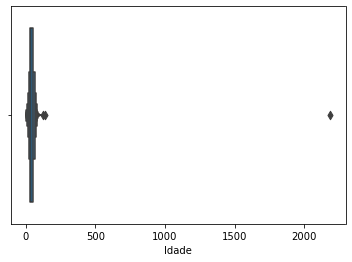

In [23]:
limite_idade = df['Idade'].median() + (4 * df['Idade'].std())
print('Idade limite de corte considerando 4 desvios:', limite_idade)

# Checando Idade
sns.boxenplot(x=df['Idade'])

Verificando frequência de idades acima da faixa de corte

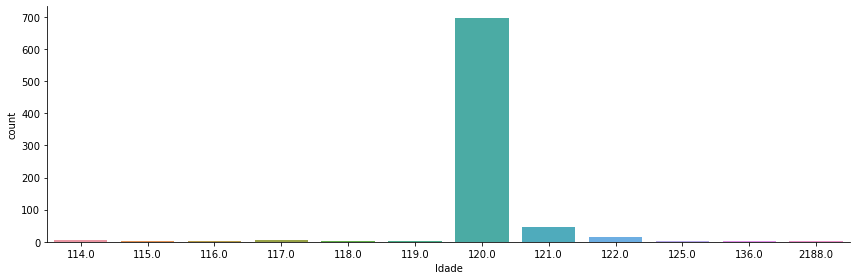

In [24]:
sns.catplot(x='Idade', kind='count', data=df.query(f'Idade > {limite_idade}'), height=4, aspect=3/1)

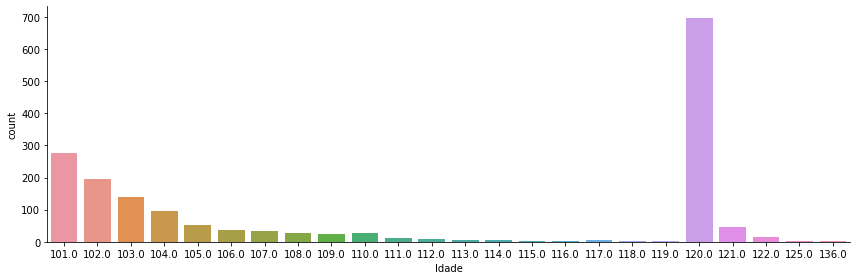

In [25]:
sns.catplot(x='Idade', kind='count', data=df.query('Idade > 100 & Idade < 150'), height=4, aspect=3/1)

Observando os gráficos acima, podemos perceber que existe uma grande concentração de ocorrências de Idade=120. Tal número parece não fazer sentido pois destoa da curva de distribuição, além de estar significativamente acima da expectativa de vida atual de aproximadamente 80 anos, segundo relatório do [IBGE](https://www.ibge.gov.br/novo-portal-destaques.html?destaque=35600). 

Desta forma, decidi fazer a exclusão dos registros com idade >= 120 e observar novamente a distribuição

In [26]:
df = df.query('Idade < 120')

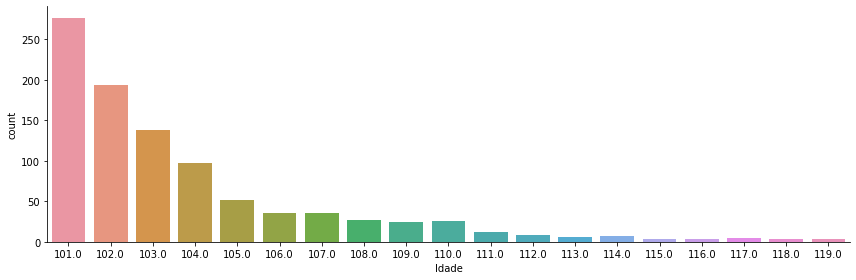

In [27]:
#sns.catplot(x='Genero', hue='Obito', kind='count', data=df)
sns.catplot(x='Idade', kind='count', data=df.query('Idade > 100'), height=4, aspect=3/1)

In [28]:
df.query(f'Idade > {limite_idade}')['Idade'].value_counts()

114.0    7
117.0    5
118.0    4
116.0    3
119.0    3
115.0    3
Name: Idade, dtype: int64

Como são pouquíssimos registros que ficaram com a Idade acima do limite de corte calculado, e parecem estar alinhados com uma distribuição normal, resolvi não utilizar o corte calculado e manter esses registros.

In [29]:
stat = get_df_stats(df)
stat

,Tipo,Qtd_Categorias,Valores,Qtd_Missing,% Missing,Qtd_0,Qtd_1,% 0,% 1
Asma,int8,3,"[-1, 0, 1]",0,0.000000,214543,15896,3.403782,0.252194
Cardiopatia,int8,3,"[-1, 0, 1]",0,0.000000,99694,458197,1.581672,7.269418
Data_Inicio_Sintomas,datetime64[ns],1140,2020-02-04 ... 2023-03-19,27634,0.438421,0,0,0.000000,0.000000
Diabetes,int8,3,"[-1, 0, 1]",0,0.000000,139987,304293,2.220931,4.827690
Diagnostico_Covid19,int64,1,[1],0,0.000000,0,6303077,0.000000,100.000000
Doenca_Hematologica,int8,3,"[-1, 0, 1]",0,0.000000,222457,4425,3.529340,0.070204
Doenca_Hepatica,int8,3,"[-1, 0, 1]",0,0.000000,221490,4626,3.513998,0.073393
Doenca_Neurologica,int8,3,"[-1, 0, 1]",0,0.000000,210035,23352,3.332261,0.370486
Doenca Renal,int8,3,"[-1, 0, 1]",0,0.000000,211531,31259,3.355996,0.495932
Genero,object,2,"[FEMININO, MASCULINO]",0,0.000000,0,0,0.000000,0.000000


# Analisando os dados

### 1. Existe diferença de incidência de covid entre homens e mulheres?

In [34]:
df['Genero'].value_counts(normalize=True)


FEMININO     0.546782
MASCULINO    0.453218
Name: Genero, dtype: float64

Segundo dados obtidos no site do [SEADE](https://populacao.seade.gov.br/), a população atual em SP está dividida em 51.3% de mulheres e 48.7% de homens
Dessa forma, a incidência de covid em mulheres ser de 54.6%, pode ser apenas um reflexo da população<br>
Outro hipótese importante é que as mulheres procuram mais atendimento médico do que os homens<br>
Poderíamos testar a inciência de covid em mulheres comparando com o total de mulheres, caso tivéssemos uma base completa incluindo os casos não confirmados

In [52]:
?sns.histplot

Signature:
sns.histplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    weights=None,
    stat='count',
    bins='auto',
    binwidth=None,
    binrange=None,
    discrete=None,
    cumulative=False,
    common_bins=True,
    common_norm=True,
    multiple='layer',
    element='bars',
    fill=True,
    shrink=1,
    kde=False,
    kde_kws=None,
    line_kws=None,
    thresh=0,
    pthresh=None,
    pmax=None,
    cbar=False,
    cbar_ax=None,
    cbar_kws=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    color=None,
    log_scale=None,
    legend=True,
    ax=None,
    **kwargs,
)
Docstring:
Plot univariate or bivariate histograms to show distributions of datasets.

A histogram is a classic visualization tool that represents the distribution
of one or more variables by counting the number of observations that fall within
disrete bins.

This function can normalize the statistic computed within each bin to estimate
frequency, density or probability mass

### 2. Faça um gráfico da mortalidade por faixas de idade

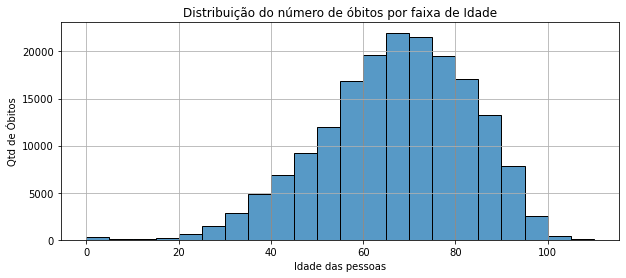

In [148]:
ax = sns.histplot(x='Idade', data=df.query('Obito==1'), stat='count', bins=[i*5 for i in range(int(max(df['Idade'])/5))])
ax.set_xlabel('Idade das pessoas')
ax.set_ylabel('Qtd de Óbitos')
ax.grid()
ax.set_title('Distribuição do número de óbitos por faixa de Idade')
ax.figure.set_size_inches(10,4)

### 3. Qual a doença pré-existente mais provável de se encontrar numa pessoa com covid?

,%
Cardiopatia,7.269418
Diabetes,4.827690
Outros_Fatores_De_Risco,2.391721
Obesidade,0.767308
Imunodepressao,0.593964
Doenca Renal,0.495932
Doenca_Neurologica,0.370486
Pneumopatia,0.312324
Asma,0.252194
Doenca_Hepatica,0.073393


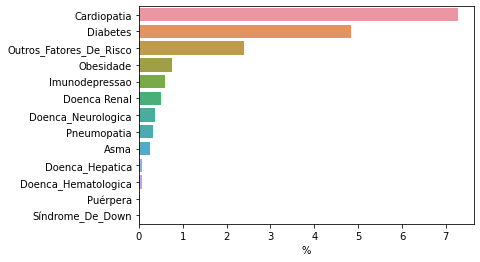

In [133]:
df_plot = pd.DataFrame(((df[COL_DOENCAS_PRE]==1).mean()*100) ).sort_values(by=[0], ascending=False)
df_plot.columns=['%']
sns.barplot(x='%', y=df_plot.index, data=df_plot)
df_plot

In [118]:
sorted((df[COL_DOENCAS_PRE]==1).mean()*100,  reverse=True)

[7.269417778015404,
 4.8276897140872626,
 2.3917207421073865,
 0.7673077768207496,
 0.5939638687580685,
 0.4959323835009472,
 0.37048571673803127,
 0.3123236476406682,
 0.25219428542599115,
 0.07339272548947125,
 0.0702038068073736,
 0.026304612810536823,
 0.022655601383260907]

In [116]:
((df[COL_DOENCAS_PRE]==1).mean()*100)

Asma                       0.252194
Cardiopatia                7.269418
Diabetes                   4.827690
Doenca_Hematologica        0.070204
Doenca_Hepatica            0.073393
Doenca_Neurologica         0.370486
Doenca Renal               0.495932
Imunodepressao             0.593964
Obesidade                  0.767308
Outros_Fatores_De_Risco    2.391721
Pneumopatia                0.312324
Puérpera                   0.026305
Síndrome_De_Down           0.022656
dtype: float64

### 4. Baseado nesses dados, faça um modelo que estime a probabilidade da pessoa morrer, uma vez que está contaminada com covid, e considerando os inputs de idade, gênero e doenças pré-existentes

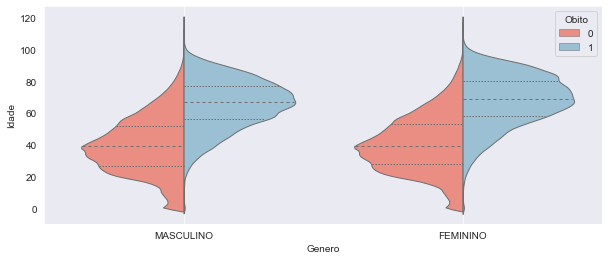

In [205]:


# Violinplot Displays distribution of data
# across all levels of a category.
ax = sns.violinplot(x="Genero", y="Idade", hue="Obito", data=df, split=True, height=5, inner="quart", linewidth=1)

ax.grid()
ax.figure.set_size_inches(10,4)



AttributeError: 'AxesSubplot' object has no attribute 'palette'

In [ ]:
df.groupby('Genero')['Idade'].describe()

In [ ]:
df.isnull().sum().sort_values()

In [ ]:
df[df['Puérpera']==1].to_clipboard()

In [ ]:
df['Diagnostico_Covid19'].unique()

In [ ]:
sns.catplot(x="Genero", y="Obito", data=df).set(ylim=(0, 1))

In [61]:
import matplotlib.pyplot as plt

df_0 = df.query('Obito==0')['Idade']
df_1 = df.query('Obito==1')['Idade']

<AxesSubplot:xlabel='Genero', ylabel='Obito'>

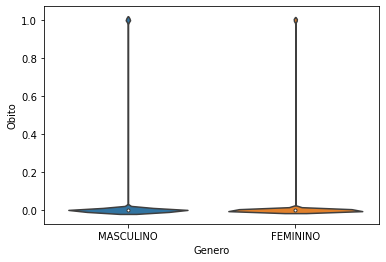

In [152]:
sns.violinplot(x='Genero', y='Obito', data=df, stat='count')

(array([[1.47401e+05, 2.03791e+05, 3.77376e+05, 7.78686e+05, 8.92509e+05,
         8.32628e+05, 8.45404e+05, 5.94798e+05, 5.72280e+05, 3.88783e+05,
         2.10744e+05, 1.40717e+05, 6.47900e+04, 3.23450e+04, 6.25400e+03,
         4.99000e+02, 1.22000e+02, 2.30000e+01],
        [1.47524e+05, 2.03896e+05, 3.77673e+05, 7.80008e+05, 8.96041e+05,
         8.38645e+05, 8.56428e+05, 6.08084e+05, 5.95370e+05, 4.18096e+05,
         2.36705e+05, 1.68127e+05, 8.42100e+04, 4.64650e+04, 1.00610e+04,
         7.94000e+02, 1.40000e+02, 2.50000e+01]]),
 array([  1.        ,   7.61111111,  14.22222222,  20.83333333,
         27.44444444,  34.05555556,  40.66666667,  47.27777778,
         53.88888889,  60.5       ,  67.11111111,  73.72222222,
         80.33333333,  86.94444444,  93.55555556, 100.16666667,
        106.77777778, 113.38888889, 120.        ]),
 <a list of 2 BarContainer objects>)

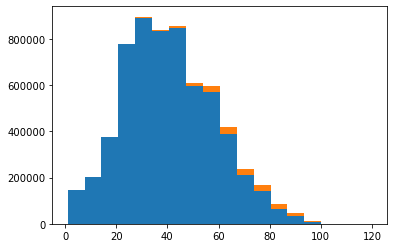

In [74]:
plt.subplot(111)
plt.hist([df_0, df_1], 
             bins=18, 
             range=(1, 120), 
             stacked=True)

In [ ]:
df['Genero'].value_counts()

In [ ]:
df[df['Asma']==1]

In [ ]:
sns.boxplot(df['Idade'])

c:\Users\U009262\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Idade'>

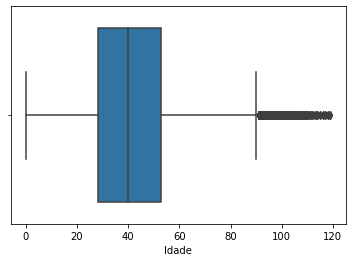

In [38]:
# Pessoa mais velha reconhecida segundo o Guinnes = 122 anos
df = df[df['Idade']<=120]
sns.boxplot(df['Idade'])

In [ ]:
sns.histplot(df['Idade'], bins=15)

In [ ]:
df['Genero'].value_counts()

In [ ]:
df.corr()

In [ ]:
df_tmp = pd.DataFrame()
df_tmp['Coluna'] = df.columns

In [ ]:
df_tmp['IsNull'] = df.isnull().sum()
df_tmp

In [ ]:
sns.heatmap(data=df.corr(),annot=True,linewidths=0.2,cmap='coolwarm', square=True);

{'A': '#FF0000', 'B': '#0000ff', 'Total': '#999999', 'C': '#00ff00'}


C:\Users\U009262\AppData\Local\Temp/ipykernel_6940/1378377306.py:11: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unique = a["Program"].append(b["Program"]).unique()


<Figure size 432x288 with 0 Axes>

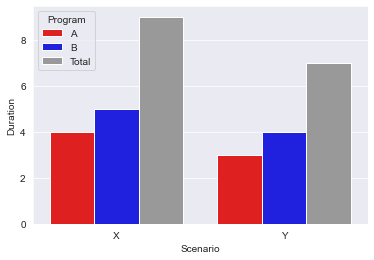

<Figure size 432x288 with 0 Axes>

In [196]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
fig, ax = plt.subplots()

a = pd.DataFrame({'Program': ['A', 'A', 'B', 'B', 'Total', 'Total'],
                  'Scenario': ['X', 'Y', 'X', 'Y', 'X', 'Y'],
                  'Duration': [4, 3, 5, 4, 9, 7]})

unique = a["Program"].append(b["Program"]).unique()


palette = {'A': '#FF0000', 'B': '#0000ff', 'Total': 'k', 'C': '#00ff00', "Total":"#999999"}

ax = sns.barplot(data=a, x='Scenario', y='Duration', hue='Program', palette=palette)


